<a href="https://colab.research.google.com/github/ShiraWild/AppLearner/blob/Shira-CNN---EDA/Notebooks/initial_analysis_dns_and_collector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis

In [3]:
# imports 
from google.colab import drive
import json
import shutil
import os
import zipfile
import warnings
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns 
import statistics
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
import src.framework__data_set as ds
import random
random.seed(10)

# Data Understanding
Let's start our analysis by examining the data and assessing the applications. While we have three metrics available (Container memory, Container CPU, and Node memory), we'll focus on only two of them (Container memory, Container CPU). Therefore, we'll begin by evaluating the usage data for Container memory.

In [ ]:
hist = ds.get_amount_of_data_per_application(
    metric="container_mem",
    path_to_data="./data/"
)
print("Number of applications: ",len(hist))
print("Example of 15 applications, and number of samples for each: ",hist[:15])

Number of applications:  417
Example of 15 applications, and number of samples for each:  [('kube-rbac-proxy', 7718487), ('cni-plugins', 3142572), ('driver-registrar', 2820695), ('oauth-proxy', 1942223), ('collector', 1701727), ('nmstate-handler', 1587755), ('keepalived', 1587373), ('node-exporter', 1586814), ('coredns', 1586715), ('whereabouts-cni-bincopy', 1586041), ('bridge-marker', 1583131), ('whereabouts-cni', 1580344), ('egress-router-binary-copy', 1578966), ('kube-multus-additional-cni-plugins', 1577492), ('coredns-monitor', 1576538)]


In [ ]:
hist = ds.get_amount_of_data_per_application(
    metric="container_cpu",
    path_to_data="./data/"
)
print("Number of applications: ",len(hist))
print("Example of 15 applications, and number of samples for each: ",hist[:15])

Number of applications:  378
Example of 15 applications, and number of samples for each:  [('kube-rbac-proxy', 7578821), ('oauth-proxy', 1885203), ('collector', 1602125), ('coredns-monitor', 1564425), ('network-metrics-daemon', 1559549), ('nmstate-handler', 1556575), ('dns-node-resolver', 1554940), ('dns', 1554337), ('node-ca', 1552028), ('kube-multus-additional-cni-plugins', 1549615), ('network-check-target-container', 1547871), ('cni-plugins', 1546571), ('keepalived', 1545578), ('coredns', 1545393), ('node-exporter', 1545075)]


# Data Visualization
We can gain insights into the data by analyzing the graphs and their trends. As an illustration, consider the two plots below of the 'bridge-maker' application with container CPU information. To generate these plots, we utilized the 'get_data_set' function, which accepts 'metric' and 'application_name' as inputs and extracts the corresponding data from the json files. The output is a dataset object comprising a list of pandas dataframes with two columns - one for time and one for the sample.

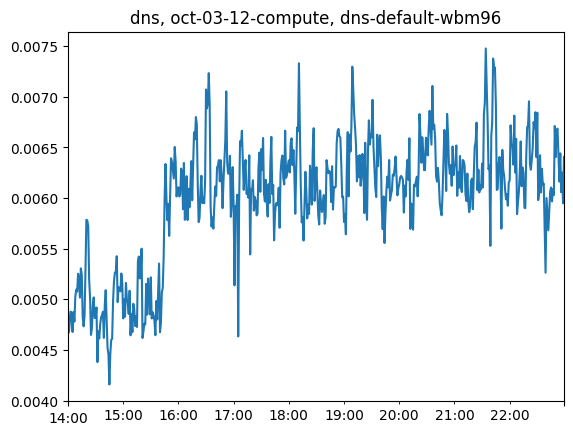

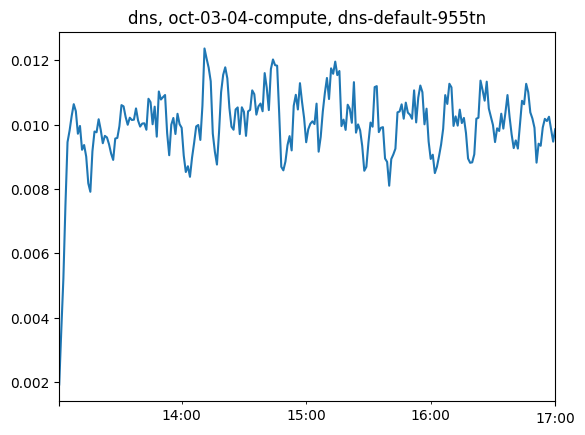

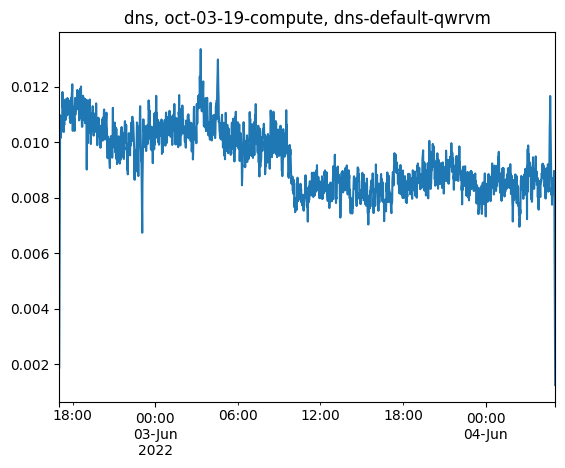

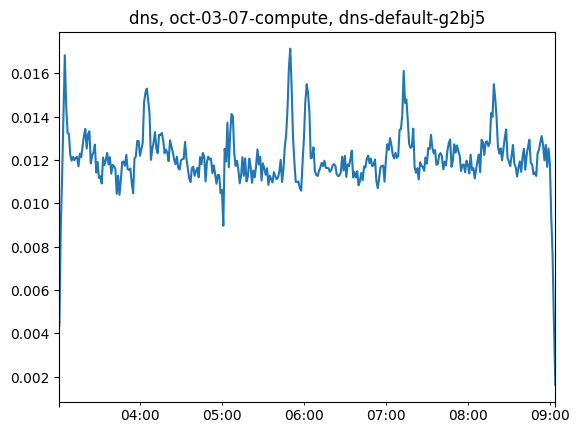

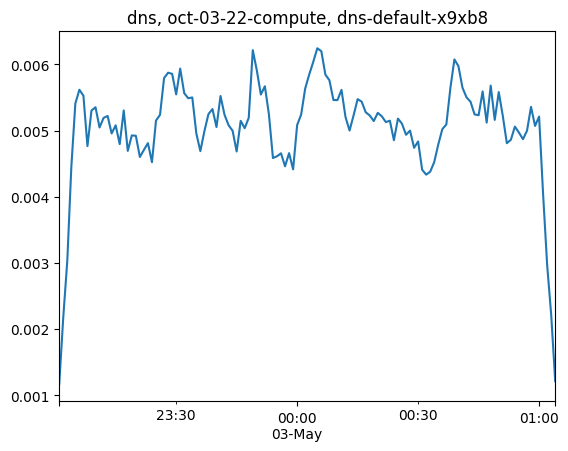

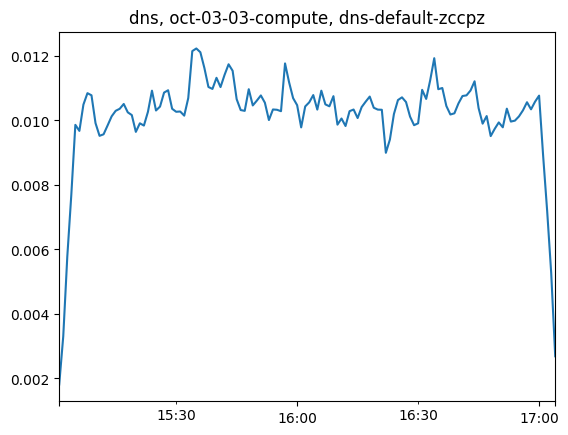

In [ ]:
dataset = ds.get_data_set(
    metric="container_cpu",
    application_name="dns",
    path_to_data="./data/"
)

dataset.plot_dataset(number_of_samples=3)

Each application's data is organized into multiple time series, each of which is continuous and sampled at one-minute intervals without any interruptions during a single run. To obtain more generalized data, the sampling rate can be adjusted. In the example below, the dataset has been modified to sample data every five minutes, and any series with fewer than 10 samples has been removed:

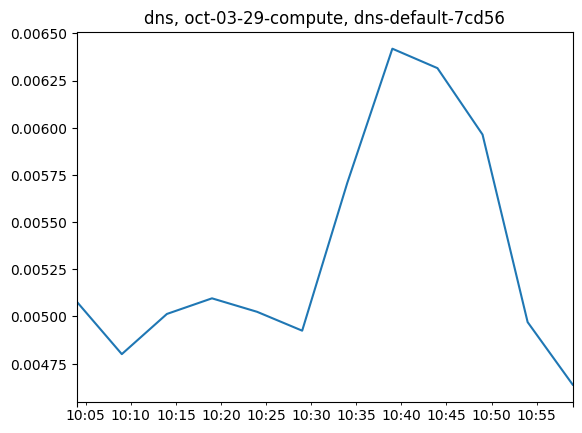

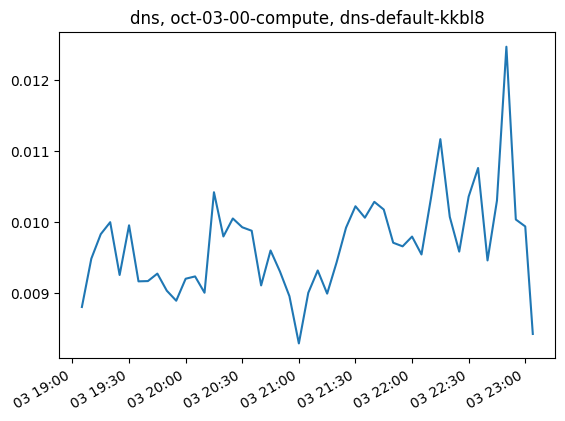

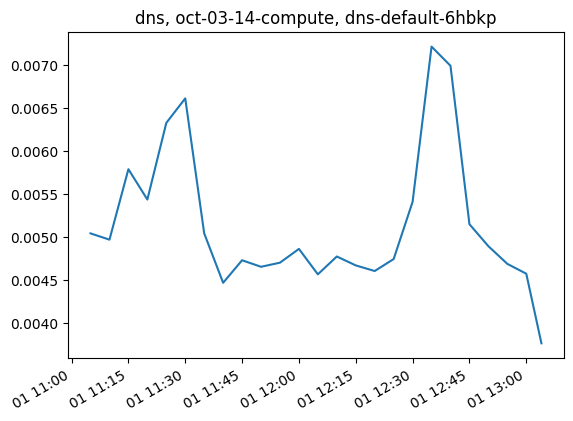

In [ ]:
dataset.sub_sample_data(sub_sample_rate=5)
dataset.filter_data_that_is_too_short(data_length_limit=10)
dataset.plot_dataset(number_of_samples=3)

The data is not scaled and exhibits considerable variability. It is necessary to scale the data.

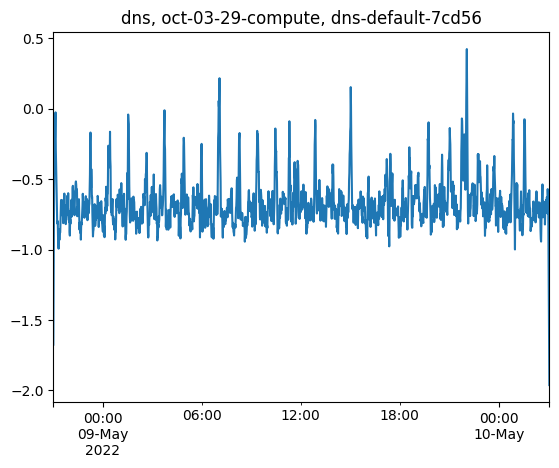

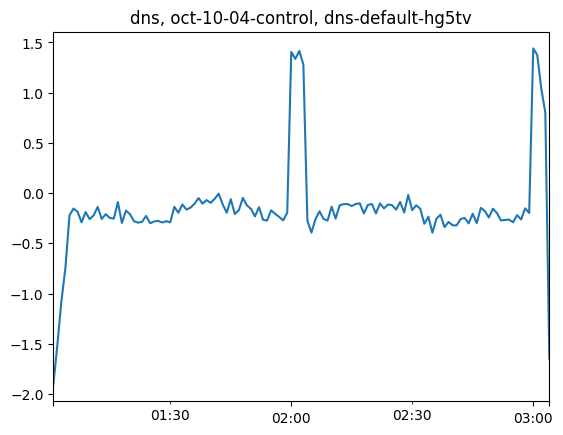

In [ ]:
dataset.scale_data()
dataset.plot_dataset(number_of_samples=2)

To prepare the data for modeling, it can be split into training and testing sets. This involves extracting 'length_to_predict' samples from each time series in the training set. This technique emulates a real-world scenario where one has the initial sequence of the time series (all the data up to a certain point) and must predict the next 'length_to_predict' number of samples.

In [ ]:
train, test = dataset.split_to_train_and_test(length_to_predict=5)

# Data preperation

In [4]:

json_objects = []

# Mounting Google Drive to access the zip file
drive.mount('/content/drive')

zip_path = '/content/drive/My Drive/Prometheus Data/OperatreFirst_PrometheusData_AppLearner.zip'
json_dir_path = '/content/OperatreFirst_PrometheusData_AppLearner'

# Extracting the zip files 
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Getting list of files in the zip
    file_names = zip_ref.namelist()
    # Extracting the files that start with 'container_cpu_' string
    for file_name in file_names:
      zip_ref.extract(file_name, json_dir_path)

# Looping through each extracted JSON file, reading and saving it as a JSON file in the Colab environment 
for file_name in os.listdir(json_dir_path):
    if file_name.startswith('container') and file_name.endswith('.json'):
        with open(os.path.join(json_dir_path, file_name), 'r') as f:
            json_data = [json.loads(line) for line in f]
        with open(f'{file_name[:-5]}_subset.txt', 'w') as f:
            f.write(json.dumps(json_data, indent=4))
# Delete the memory files - irrelevant
dir_path = '/content/OperatreFirst_PrometheusData_AppLearner/OperatreFirst_PrometheusData_AppLearner'
for file_name in os.listdir(dir_path):
    if not file_name.startswith('container_cpu_'):
        os.remove(os.path.join(dir_path, file_name))
    else: # Store the relevant json files as a dictionary
        if file_name.endswith('.json'):
          with open(os.path.join(dir_path, file_name), 'r') as f:
            json_data = json.load(f)
          json_objects.append(json_data)

Mounted at /content/drive


In [5]:
num_objects = len(json_objects)
print(f"There are {num_objects} json files.")

There are 5 json files.


In [6]:
#Creating the df - each row represents a dataset (including all the values of the data)

json_objects = json_objects
dataframe = pd.DataFrame(columns=["application","namespace", "node","pod","start", "stop", "data"])
i=0
for data in json_objects: 
  for key, value in data.items():
      app_data = key.split(", ")
      application, namespace, node, pod = app_data[0],app_data[1],app_data[2], app_data[3]
      if application == 'dns' or application == 'collector':
        for v in value:
            time = v['start']
            start = datetime.strptime(v["start"], "%Y-%m-%d %H:%M:%S")
            stop = datetime.strptime(v["stop"], "%Y-%m-%d %H:%M:%S")
            data = v["data"]
            dataframe.loc[i] = [application,namespace,node,pod, start, stop,data]
            i += 1
      

## EDA - Collector Application

In [9]:
df_collector = dataframe.loc[dataframe['application'] == 'collector'].copy()

num_all_zeros = len(df_collector.loc[df_collector['data'].apply(lambda x: all(val == 0 for val in x))])
print(f"The number of dataframes with all zeros CPU consumption values is: {num_all_zeros}\n")


The number of dataframes with all zeros CPU consumption values is: 0



As we can see,  there are no dataframes in the 'collector' application with all zero values. This finding indicates that the data is valid and does not exhibit any instances of complete absence of CPU consumption.

In [11]:
df_collector.head(5)

,application,namespace,node,pod,start,stop,data
0,collector,openshift-logging,oct-03-14-compute,collector-45ggj,2022-05-28 17:00:00,2022-05-28 17:04:00,"[0.0320022991333341, 0.0262894255359178, 0.020..."
1,collector,openshift-logging,oct-03-14-compute,collector-45ggj,2022-05-28 21:01:00,2022-05-29 03:04:00,"[0.0091724990056144, 0.0154374696894289, 0.021..."
2,collector,openshift-logging,oct-03-14-compute,collector-45ggj,2022-05-29 05:01:00,2022-05-30 03:04:00,"[0.006033915309428, 0.0122509814599761, 0.0192..."
3,collector,openshift-logging,oct-03-14-compute,collector-45ggj,2022-05-30 05:01:00,2022-05-30 19:04:00,"[0.0126865943562504, 0.0207211524625931, 0.029..."
4,collector,openshift-logging,oct-03-14-compute,collector-45ggj,2022-05-30 21:01:00,2022-05-31 01:04:00,"[0.0067857535893381, 0.0126782464223269, 0.019..."


In [12]:
def aggregate_time(df, n, ma):
    """
    ma - the k for the rolling average window
    """
    start = df['start']
    data_list = df['data']
  
    med_data = []
    agg_time = []
    min_data = []
    max_data = []
    mean_data = []
    roll_avg = []
    for i in range(0, len(data_list), n):
      agg_time.append(start + timedelta(minutes = i))
      temp =data_list[i: i+n] 
      temp_med = np.median(temp)
      temp_mean = np.mean(temp)
      temp_min = min(temp)
      temp_max = max(temp)
      med_data.append(temp_med)
      min_data.append(temp_min)
      max_data.append(temp_max)
      mean_data.append(temp_mean)
      if i> ma:
        roll_data = data_list[i-ma:i]
        roll_avg.append(np.mean(roll_data))
      else:
        roll_avg.append(temp_mean)
  
    # Create dataframe
    app = [df['application'] for j in med_data]
    namespace = [df['namespace'] for j in med_data]
    node = [df['node'] for j in med_data]
    pod = [df['pod'] for j in med_data]
    app_df = pd.DataFrame({'application': app,
                            'namespace': namespace,
                            'node':node,
                            'pod':pod,
                          'time': agg_time,
                          'median': med_data,
                            'min': min_data,
                            'max': max_data,
                           'mean': mean_data,
                           'rolling_average':roll_avg})
    return app_df


In [ ]:
dfs_30 = []

for index, row in df_collector.iterrows():
  print("Start:", row['start'])
  print("End:", row['stop'])
  print("The number of minutes information for CPU consumption in the dataframe is: ", len(row['data']))
  print("------------")
  app_df = aggregate_time(row, 30, ma=120)
  dfs_30.append(app_df)

In [14]:
print("\nAn example for a dataframe:")
dfs_30[50].head(2)# create a list of sample dataframes


An example for a dataframe:


,application,namespace,node,pod,time,median,min,max,mean,rolling_average
0,collector,openshift-logging,oct-03-07-compute,collector-48kdf,2022-06-07 01:01:00,0.284603,0.066266,0.349879,0.265529,0.265529
1,collector,openshift-logging,oct-03-07-compute,collector-48kdf,2022-06-07 01:31:00,0.289773,0.046554,0.370590,0.275501,0.275501


In [15]:
df_collector_concat = pd.concat(dfs_30)


An illustration of statistics for a single dataset can be examined.

In [16]:
# check for null values
print('Null values:\n', dfs_30[40].isnull().sum())

# compute basic statistics
print('\nStatistics:\n', dfs_30[40].describe())

Null values:
 application        0
namespace          0
node               0
pod                0
time               0
median             0
min                0
max                0
mean               0
rolling_average    0
dtype: int64

Statistics:
           median        min        max       mean  rolling_average
count  20.000000  20.000000  20.000000  20.000000        20.000000
mean    0.205065   0.173575   0.281312   0.214763         0.220493
std     0.020458   0.030372   0.089388   0.030338         0.028410
min     0.174880   0.050009   0.189692   0.166993         0.166993
25%     0.190100   0.174069   0.223143   0.193613         0.206412
50%     0.194718   0.180632   0.256915   0.210149         0.213548
75%     0.218496   0.181855   0.314822   0.233609         0.233717
max     0.243795   0.200704   0.567495   0.301851         0.301851


The distribution of the top 35 most commonly used applications across all dataframes is displayed in a bar plot, based on the percentage of dataframes in which they are present, without reference to the duration of time recorded for each dataframe.

The second y-axis displays the average CPU consumption for each application. The aggregation is at the application level, which may obscure variations in resource usage at the pod/node level, but still offers a valuable high-level overview of usage trends for each application.

The application 'kube-rbac-proxy' stands out, accounting for over 8% of the total dataframes, which is a significant deviation from the other applications that are more evenly distributed.

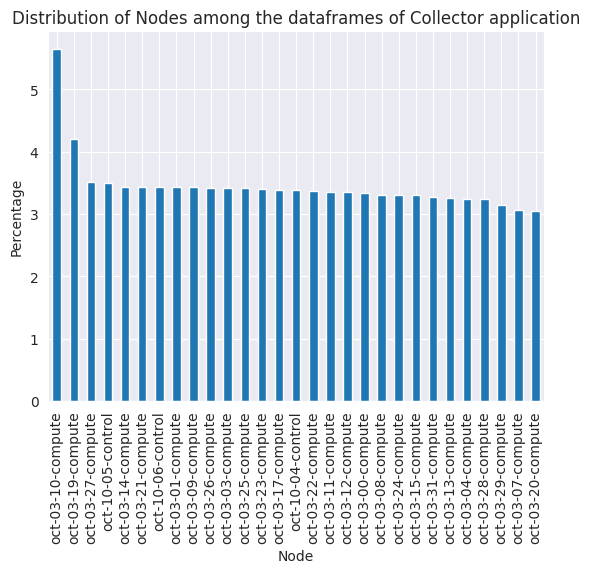

In [39]:
# Count the number of occurrences of each node
node_counts = df_collector_concat['node'].value_counts(normalize=True).sort_values(ascending=False)[:30]*100

fig, ax = plt.subplots()
node_counts.plot.bar(ax=ax, color='C0')
ax.set_title('Distribution of Nodes among the dataframes of Collector application')
ax.set_xlabel('Node')
ax.set_ylabel('Percentage')

plt.show()


A bar plot is used to exhibit the distribution of the top 30 most frequent nodes among all 'collector' dataframes based on the percentage of dataframes in which they occur, without considering the duration of time recorded for each dataframe. As we can see, the most popular node for 'collector' app is 'oct-03-10-compute'

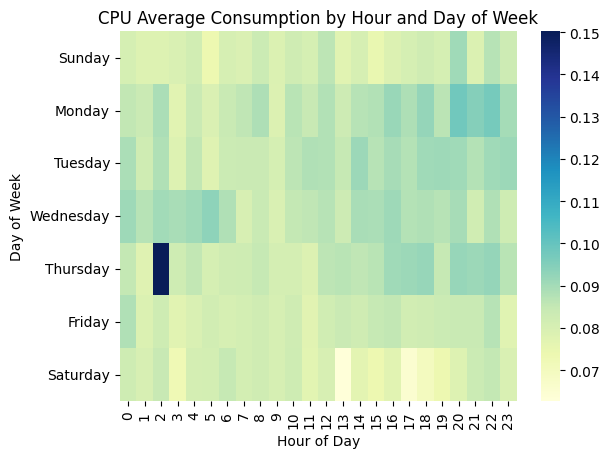

In [19]:
warnings.filterwarnings('ignore')

# Create new columns 
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_collector_concat['day_of_week'] = df_collector_concat['time'].dt.strftime('%A')
df_collector_concat['day_of_week'] = pd.Categorical(df_collector_concat['day_of_week'], ordered_days)
df_collector_concat['hour_of_day'] = df_collector_concat['time'].dt.hour

# Group by day of the week and hour of the day and calculate the median CPU consumption
grouped = df_collector_concat.groupby(['day_of_week', 'hour_of_day'])['mean'].mean().reset_index()
heatmap_data = grouped.pivot('day_of_week', 'hour_of_day', 'mean').reindex(ordered_days)
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('CPU Average Consumption by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


In [20]:
# Calculate average CPU consumption among all collector apps for each hour
average_cpu_by_hour = df_collector_concat.groupby('hour_of_day')['mean'].mean()

# Print the average CPU consumption for each hour
print("Average CPU Consumption by Hour (All Collector Apps):")
for hour, avg_cpu in average_cpu_by_hour.items():
    print(f"Hour {hour}: {avg_cpu:.2f}")



Average CPU Consumption by Hour (All Collector Apps):
Hour 0: 0.09
Hour 1: 0.08
Hour 2: 0.09
Hour 3: 0.08
Hour 4: 0.08
Hour 5: 0.08
Hour 6: 0.08
Hour 7: 0.08
Hour 8: 0.08
Hour 9: 0.08
Hour 10: 0.08
Hour 11: 0.08
Hour 12: 0.09
Hour 13: 0.08
Hour 14: 0.08
Hour 15: 0.08
Hour 16: 0.09
Hour 17: 0.08
Hour 18: 0.09
Hour 19: 0.08
Hour 20: 0.09
Hour 21: 0.09
Hour 22: 0.09
Hour 23: 0.08


In [26]:
average_cpu_all = df_collector_concat['mean'].mean()
print(f"Average CPU Consumption across all dataframes: {average_cpu_all:.2f}")


Average CPU Consumption across all dataframes: 0.08


In [27]:
thursday_cpu = df_collector_concat.loc[df_collector_concat['day_of_week'] == 'Thursday', 'mean']
num_stds = (thursday_cpu.mean() - average_cpu_all) / thursday_cpu.std()

print(f"The Thursday CPU consumption is approximately {num_stds:.2f} standard deviations above the mean.")


The Thursday CPU consumption is approximately 0.05 standard deviations above the mean.


The plot showcases the median CPU consumption categorized by both the day of the week and the hour of the day, providing insights into consumption patterns. 

Overall, the plot reveals a relatively uniform distribution of CPU consumption across different time intervals, with minor variations of around 0.01. 

However, a noticeable deviation occurs on Thursday at 2 am, where the CPU consumption reaches approximately 0.15, exceeding the mean value of 0.08. Nonetheless, upon further analysis, this deviation is found to be only 0.05 standard deviations away from the mean, indicating that the difference is not statistically significant.

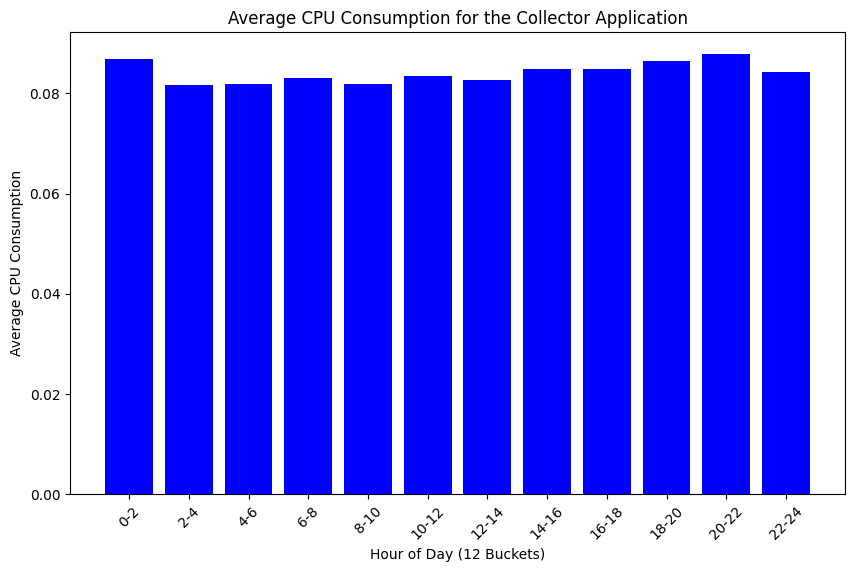

In [28]:
# Create hour bins
df_collector_concat['hour'] = df_collector_concat['time'].dt.hour
df_collector_concat['hour_bin'] = pd.cut(df_collector_concat['hour'], bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24], labels=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24'])

# Calculate hourly averages
hourly_avg_collector = df_collector_concat.groupby('hour_bin')['mean'].mean()

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(hourly_avg_collector.index, hourly_avg_collector, color='b')
plt.xlabel('Hour of Day (12 Buckets)')
plt.ylabel('Average CPU Consumption')
plt.title('Average CPU Consumption for the Collector Application')
plt.xticks(rotation=45)
plt.show()


We can observe a relatively uniform distribution of CPU consumption across the different hours of the day.

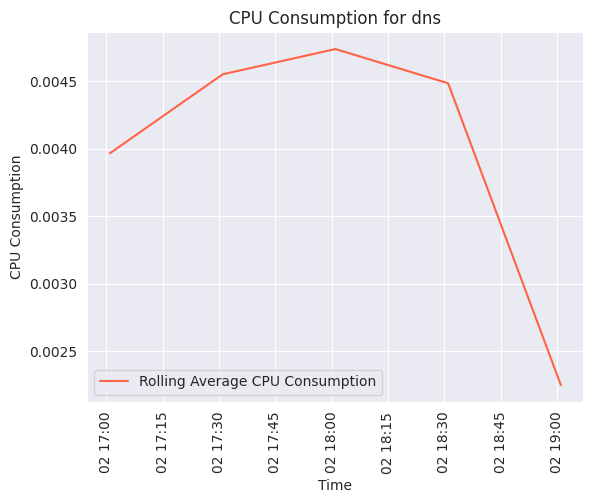

In [43]:
sns.set_style("darkgrid")  # set the seaborn style
sns.lineplot(data=dfs_30[12], x='time', y='rolling_average', color='tomato', label='Rolling Average CPU Consumption')
plt.title(f'CPU Consumption for {dfs_30[12]["application"].iloc[0]}')
plt.xlabel('Time')
plt.ylabel('CPU Consumption')
plt.xticks(rotation=90)

plt.legend(loc='lower left')

plt.show()


The plot depicts the CPU consumption over time for a specific time interval of  the application 'collector'. It indicates that the trend is generally consistent, followed by an abrupt drop in which the application's CPU consumption falls to half of its previous level within half an hour.

## EDA - DNS Application

In [32]:
df_dns = dataframe.loc[dataframe['application'] == 'dns'].copy()

num_all_zeros = len(df_dns.loc[df_dns['data'].apply(lambda x: all(val == 0 for val in x))])
print(f"The number of dataframes with all zeros CPU consumption values is: {num_all_zeros}\n")


The number of dataframes with all zeros CPU consumption values is: 0



As we can see,  there are no dataframes in the 'dns' application with all zero values. This finding indicates that the data is valid and does not exhibit any instances of complete absence of CPU consumption.

In [ ]:
dfs_30_dns = []


for index, row in df_dns.iterrows():
  print("Start:", row['start'])
  print("End:", row['stop'])
  print("The number of minutes information for CPU consumption in the dataframe is: ", len(row['data']))
  print("------------")
  app_df = aggregate_time(row, 30, ma=120)
  dfs_30_dns.append(app_df)

In [36]:
print("\nAn example for a dataframe:")
dfs_30_dns[50].head(2)# create a list of sample dataframes


An example for a dataframe:


,application,namespace,node,pod,time,median,min,max,mean,rolling_average
0,dns,openshift-dns,oct-03-14-compute,dns-default-6hbkp,2022-06-08 13:01:00,0.004850,0.001546,0.005141,0.004609,0.004609
1,dns,openshift-dns,oct-03-14-compute,dns-default-6hbkp,2022-06-08 13:31:00,0.004912,0.004482,0.005205,0.004894,0.004894


In [37]:
df_dns_concat = pd.concat(dfs_30_dns)

# check for null values
print('Null values:\n', dfs_30_dns[40].isnull().sum())

# compute basic statistics
print('\nStatistics:\n', dfs_30_dns[40].describe())


Null values:
 application        0
namespace          0
node               0
pod                0
time               0
median             0
min                0
max                0
mean               0
rolling_average    0
dtype: int64

Statistics:
          median       min       max      mean  rolling_average
count  9.000000  9.000000  9.000000  9.000000         9.000000
mean   0.004764  0.003911  0.005212  0.004733         0.004984
std    0.000711  0.001547  0.000388  0.000736         0.000138
min    0.002876  0.001149  0.004237  0.002803         0.004653
25%    0.004926  0.004581  0.005253  0.004928         0.004979
50%    0.004989  0.004618  0.005274  0.005011         0.005011
75%    0.005034  0.004737  0.005366  0.005014         0.005039
max    0.005119  0.004789  0.005603  0.005137         0.005137


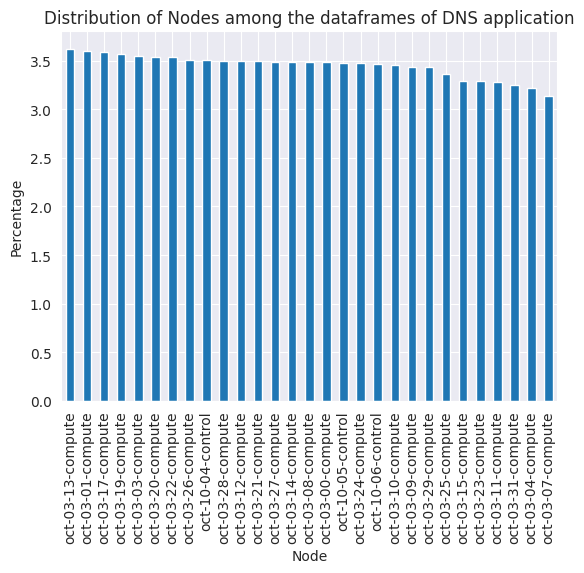

In [38]:
# Count the number of occurrences of each node
node_counts = df_dns_concat['node'].value_counts(normalize=True).sort_values(ascending=False)[:30]*100

fig, ax = plt.subplots()
node_counts.plot.bar(ax=ax, color='C0')
ax.set_title('Distribution of Nodes among the dataframes of DNS application')
ax.set_xlabel('Node')
ax.set_ylabel('Percentage')

plt.show()


A bar plot is used to exhibit the distribution of the top 30 most frequent nodes among all 'collector' dataframes based on the percentage of dataframes in which they occur, without considering the duration of time recorded for each dataframe. As we can see, the the nodes frequency distribution is pretty uniform among the 30 top frequent nodes.

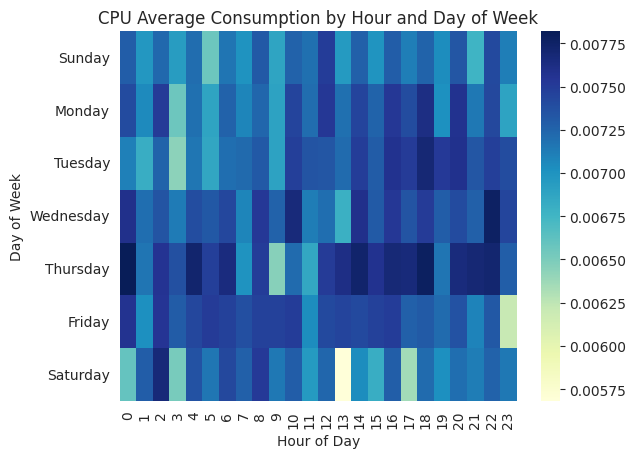

In [40]:
warnings.filterwarnings('ignore')

# Create new columns 
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_dns_concat['day_of_week'] = df_dns_concat['time'].dt.strftime('%A')
df_dns_concat['day_of_week'] = pd.Categorical(df_dns_concat['day_of_week'], ordered_days)
df_dns_concat['hour_of_day'] = df_dns_concat['time'].dt.hour

# Group by day of the week and hour of the day and calculate the median CPU consumption
grouped = df_dns_concat.groupby(['day_of_week', 'hour_of_day'])['mean'].mean().reset_index()
heatmap_data = grouped.pivot('day_of_week', 'hour_of_day', 'mean').reindex(ordered_days)
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('CPU Average Consumption by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


The plot displays the median CPU consumption categorized by both the day of the week and the hour of the day, allowing us to identify consumption patterns.

Upon analysis, the plot reveals a relatively consistent distribution of CPU consumption across various time intervals. 

Although the colors may appear different, a closer examination shows that the scale of changes is minimal. Consequently, there are no significant variations in CPU consumption, and the overall pattern remains quite consistent throughout the different time intervals.

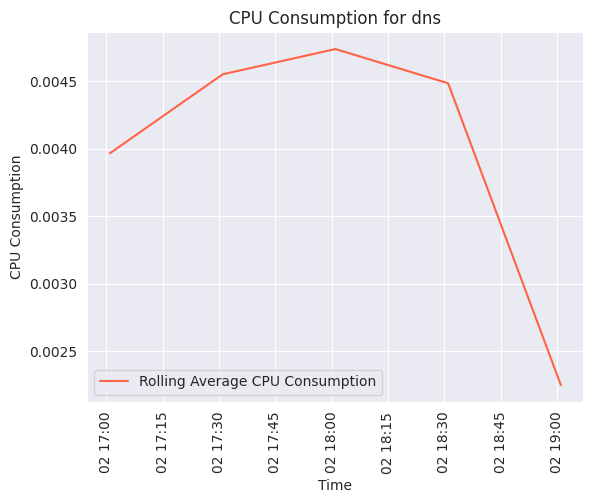

In [42]:
sns.set_style("darkgrid")  # set the seaborn style
sns.lineplot(data=dfs_30_dns[12], x='time', y='rolling_average', color='tomato', label='Rolling Average CPU Consumption')
plt.title(f'CPU Consumption for {dfs_30_dns[12]["application"].iloc[0]}')
plt.xlabel('Time')
plt.ylabel('CPU Consumption')
plt.xticks(rotation=90)

plt.legend(loc='lower left')

plt.show()


The plot depicts the CPU consumption over time for a specific time interval of  the application 'dns'. It indicates that the trend is generally consistent, followed by an abrupt drop in which the application's CPU consumption falls to half of its previous level within half an hour.